<script>
document.addEventListener("DOMContentLoaded", function() {
    // Target the input areas for code cells but not Markdown
    let codeCells = document.querySelectorAll('.jp-Cell.jp-CodeCell .jp-InputArea');

    codeCells.forEach(cell => {
        cell.style.display = "none";  // Hide code cells, leave output and markdown visible
    });
});
</script>


# Prediction of Poisonous Mushrooms
by Nicolas Martin


***

## 1. Business Understanding

This project focuses on developing a machine learning model to classify mushrooms as either edible or poisonous based on various physical characteristics. The problem is framed as a binary classification task, with the goal of building a highly accurate predictive model.

The project follows the guidelines of the Kaggle [Binary Prediction of Poisonous Mushrooms](https://www.kaggle.com/competitions/playground-series-s4e8)  competition, where models are evaluated on a separate test dataset using the Matthews correlation coefficient (MCC). MCC is a robust metric for binary classification, as it considers true and false positives and negatives, making it particularly useful when class distributions are imbalanced. The coefficient ranges from -1 (completely wrong predictions) to +1 (perfect predictions), with 0 indicating no better than random guessing. [Source: [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)]

An LGBM Classifier will be used for this data as this is a large dataset, with many categorical variables, and high-cardinality. This model will be created as is and then tuned for better performance.

## 2. Data Understanding

This competition contains two datasets:
1. Train Dataset: This dataset consists of 3,116,945 rows and 22 columns. It will serve as the foundation for our analysis and model development.
2. Test Dataset: This dataset contains 2,077,964 rows and 21 columns. It will be used to run the final model, and the resulting predictions will be submitted for the competition.

**Observations**:

- Most of the columns are categorical (object), while only 3 are numerical.
    - It seems that the categorical features are full of one character categories.
    - Almost all of the categorical features have 20+ categories, spanning 22 to 83 categories. Knowing the definition of each feature we know that a lot of this is erroneous data.
- Missing Values are aplenty:
    - There are 4 columns with more than 80% of the data missing, and another 4 with at least 10% missing.
    - Only 1 of the numerical columns is missing data, and it is only missing 4 rows out of the entire 3.1M row dataset. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import missingno as msno

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Train Dataset
train = pd.read_csv("train.csv", index_col='id')

# Test Dataset
test = pd.read_csv("test.csv", index_col='id')

# Column Definitions
col_definitions = pd.read_csv("Column Definition.txt", delimiter="\t").rename(columns={"Definition": "definition", "Column": "column"})

#print(train.shape)
#print(test.shape)

In [3]:
def status(df):
    return pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes.values,
        'unique_values': df.nunique().values,
        'top_5_values': [df[col].value_counts().index[:5].tolist() for col in df.columns],
        'missing_values': df.isnull().sum().values,
        'missing_percentage': df.isnull().mean().mul(100).round(4).astype(str) + '%' ,
    })

train_status = status(train)
train_status = pd.merge(train_status, col_definitions, on='column', how='left')
columns_order = ['column', 'definition'] + [col for col in train_status.columns if col not in ['column', 'definition']]
train_status = train_status[columns_order]

train_status = train_status.reset_index(drop=True)
train_status


,column,definition,dtype,unique_values,top_5_values,missing_values,missing_percentage
0,class,Indicates if the mushroom is poisonous (p) or ...,object,2,"[p, e]",0,0.0%
1,cap-diameter,Diameter of the cap (in mm),float64,3913,"[1.49, 3.18, 3.14, 1.51, 4.04]",4,0.0001%
2,cap-shape,"Shape of the cap (bell=b, conical=c, convex=x,...",object,74,"[x, f, s, b, o]",40,0.0013%
3,cap-surface,"Surface texture of the cap (fibrous=i, grooves...",object,83,"[t, s, y, h, g]",671023,21.5282%
4,cap-color,"Color of the cap (brown=n, buff=b, gray=g, gre...",object,78,"[n, y, w, g, e]",12,0.0004%
5,does-bruise-or-bleed,Indicates if the mushroom bruises or bleeds (t...,object,26,"[f, t, w, c, h]",8,0.0003%
6,gill-attachment,"Attachment of the gills to the stem (adnate=a,...",object,78,"[a, d, x, e, s]",523936,16.8093%
7,gill-spacing,"Spacing between the gills (close=c, distant=d,...",object,48,"[c, d, f, e, a]",1258435,40.374%
8,gill-color,"Color of the gills (brown=n, buff=b, gray=g, g...",object,63,"[w, n, y, p, g]",57,0.0018%
9,stem-height,Height of the stem (in mm),float64,2749,"[5.24, 5.92, 5.32, 5.35, 5.99]",0,0.0%


## 3. EDA

### 3.1 Target Variable Profile

The target variable, class, is binary and is split by poisonous mushrooms (p) or edible ones (e). This target variable is split relatively closely at 55% poisonous and 45% edible. As it is close this would not be considered imbalanced, and any processes that would be required to make it balanced will not be needed.

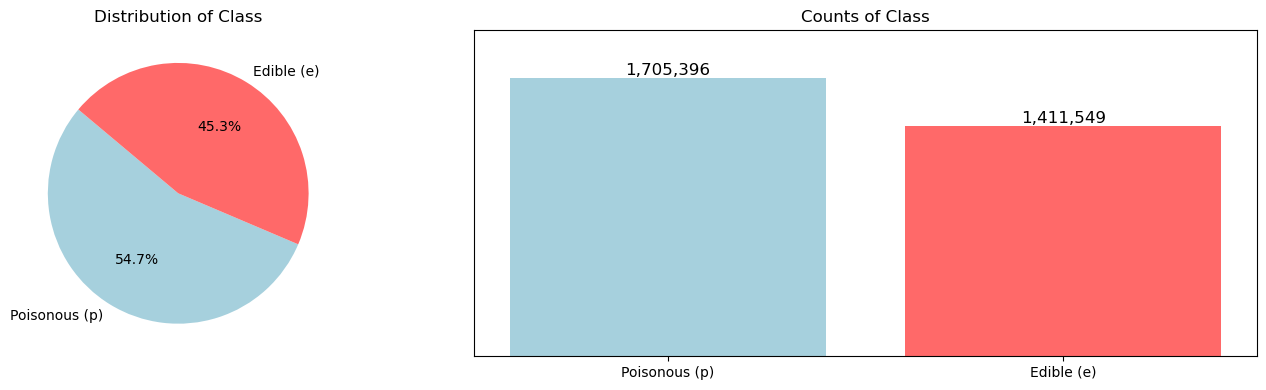

In [37]:
class_counts = train['class'].value_counts()
labels = {'p': 'Poisonous (p)', 'e': 'Edible (e)'}
class_labels = [labels[c] for c in class_counts.index]

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Pie chart
axes[0].pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=['#A6D0DD', '#FF6969'])
axes[0].set_title('Distribution of Class')

# Bar chart
bars = axes[1].bar(class_labels, class_counts, color=['#A6D0DD', '#FF6969'])

# Add count labels above bars with commas
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:,}', ha='center', va='bottom', fontsize=12)

# Remove y-axis ticks but keep the title
axes[1].set_yticks([])
axes[1].set_ylim(0,2000000)
axes[1].set_title('Counts of Class')

plt.tight_layout()
plt.show()

### 3.2 Categorical Variable Profile

As seen in the table describing the data, it was revealed that many of these categorical variables have missing data and/or a large amount of unique values. Due to this, the analysis of each categorical variable will undergo some slight transformations for the graphs. These transformations are as follows, all missing values will be grouped into "UNK" to state that they are unknown, and all values outside the top 12 in total count will be grouped into "OTH". This will help visualize the data.

First analysis is proportion of rows by variable:

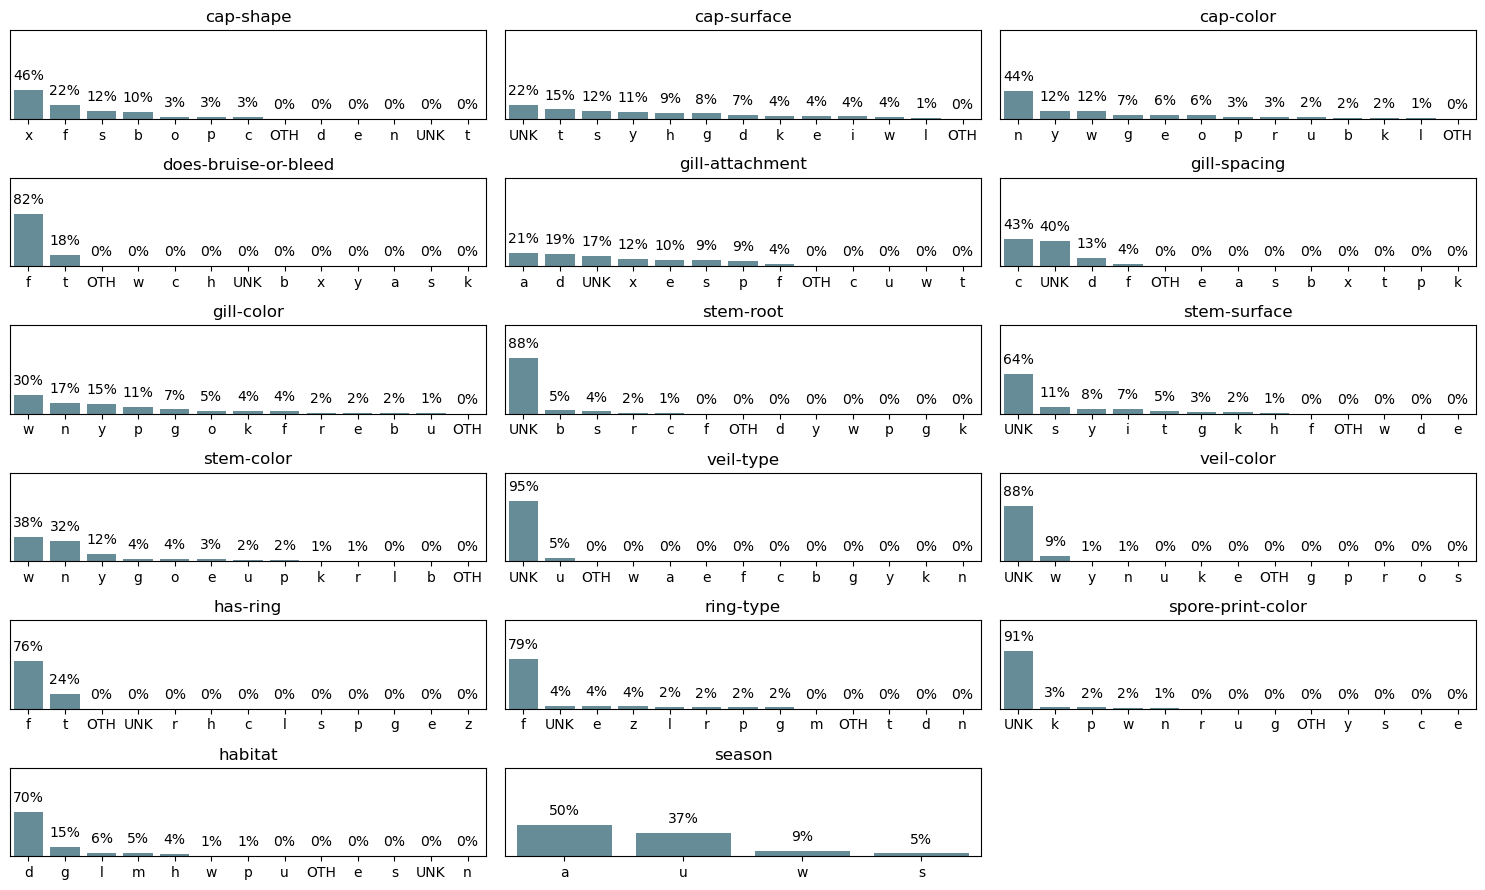

In [36]:
train_eda = train.copy()

categorical_cols = train_eda.select_dtypes(include=["object"]).drop(columns=["class"]).columns

# Set up figure size (3 columns per row)
n_cols = 3
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)

plt.figure(figsize=(15, n_rows * 1.5))  # Increase figure height for better readability

# Loop through categorical columns and create bar plots
for i, col in enumerate(categorical_cols, 1):
    # Get value counts
    value_counts = train_eda[col].value_counts(dropna=False)
    
    # Identify top 12 categories
    top_categories = value_counts.nlargest(12)
    
    # Create a new category column
    train_eda[col + "_grouped"] = train_eda[col].apply(lambda x: x if x in top_categories.index else "OTH")
    
    # Convert NaN values to "UNK"
    train_eda[col + "_grouped"] = train_eda[col + "_grouped"].fillna("UNK")
    
    # Recalculate value counts with new grouping
    grouped_counts = train_eda[col + "_grouped"].value_counts(normalize=True)
    
    # Create DataFrame for Seaborn
    df_train = pd.DataFrame({"Category": grouped_counts.index, "Proportion": grouped_counts.values})

    # Create subplot
    ax = plt.subplot(n_rows, n_cols, i)
    
    # Bar plot
    sns.barplot(x="Category", y="Proportion", color="#35768a", data=df_train, alpha=0.8)

    # Add labels above each bar as percentages
    for p in ax.patches:
        percentage = f'{p.get_height() * 100:.0f}%'  # Convert to percentage
        ax.annotate(percentage, 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

    # Formatting
    plt.title(f"{col}")
    plt.xlabel("")  # Remove x-axis label
    plt.ylabel("")  # Set y-axis title
    ax.set_yticks([])  # Remove y-axis ticks
    plt.ylim(0, 1.4)

plt.tight_layout()
plt.show()

And now looking at the behavior against the target variable:

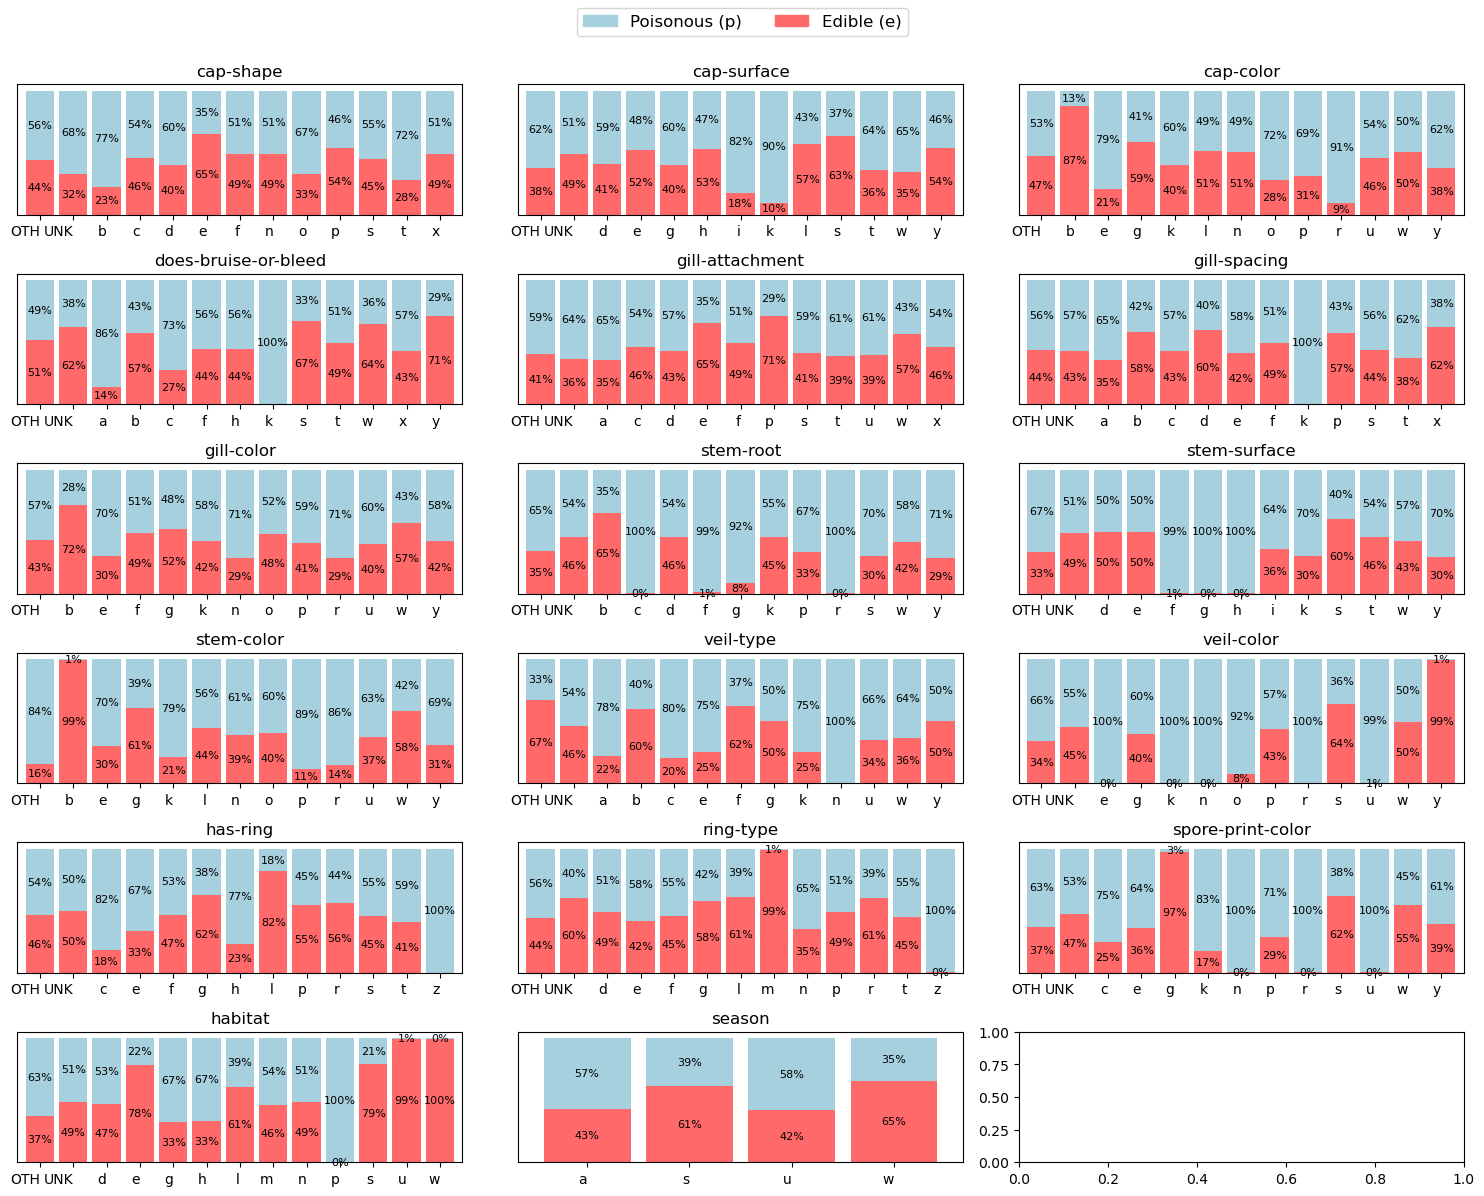

In [43]:
train_eda = train.copy()

categorical_cols = train_eda.select_dtypes(include=["object"]).drop(columns=["class"]).columns

# Set up figure size (3 columns per row)
n_cols = 3
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))  # Adjust figure size
axes = axes.flatten()  # Flatten axes array for easy indexing

# Colors for classes
class_colors = {"p": "#A6D0DD", "e": "#FF6969"}

# Loop through categorical columns and create bar plots
for i, col in enumerate(categorical_cols):
    # Get value counts
    value_counts = train_eda[col].value_counts(dropna=False)
    
    # Identify top 12 categories
    top_categories = value_counts.nlargest(12)
    
    # Create a new category column
    train_eda[col + "_grouped"] = train_eda[col].apply(lambda x: x if x in top_categories.index else "OTH")
    
    # Convert NaN values to "UNK"
    train_eda[col + "_grouped"] = train_eda[col + "_grouped"].fillna("UNK")

    # Compute proportions of each class within each category
    class_proportions = (
        train_eda.groupby([col + "_grouped", "class"]).size()
        .unstack(fill_value=0)  # Pivot table where index = category, columns = class
        .apply(lambda x: x / x.sum(), axis=1)  # Convert to proportions (100% stacked)
    )

    # Plot stacked bar chart
    ax = axes[i]
    class_proportions.plot(kind="bar", stacked=True, color=class_colors, width=0.85, ax=ax)

    # Add labels inside each bar
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:  # Only label if height > 0
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, 
                        f"{height * 100:.0f}%", ha="center", va="center", fontsize=8, color="black")

    # Formatting
    ax.set_title(f"{col}")
    ax.set_xlabel("")  # Remove x-axis label
    ax.set_ylabel("")  # Remove individual y-axis label
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

    # Remove individual legends
    ax.legend_.remove()

# Add one single legend above the whole figure
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in class_colors.values()]
fig.legend(handles, ["Poisonous (p)", "Edible (e)"], loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

### 3.3 Numerical Variable Profile

### 3.4 Correlations

### 3.5 Nullity Correlation

## 4. Feature Engineering

As an LGBM model will be used, scaling the numerical features or removing the outliers will do little for the model performance.

## 5. Modeling

### 5.1 Initial Model

### 5.2 Hyperparameter Tuning

## 6. Prepare Submission